<h1> Google Analytics Customer Revenue Prediction </h1>
<h2> 1. Business Problem  </h2>
<h3> 1.1 Introduction  </h3>
<p> Online marketing is a billion-dollar industry. Companies spend a lot of money by targeting users who visit their website once, to encourage them to buy products from them. But major part of the revenue comes from only a small percentage of users.</p>
<p> Instead of targeting everyone who visits the website, marketing budget can better be utilized If they target only those users who are most likely to purchase a product in the future</p>
<h3> 1.2 Problem Statement  </h3>
<p> Google has provided Merchandise customer dataset and no.of transactions per customer.Using this data we need to predict future revenue created by customers.</p>
<p> If we build a predictive model using G-store data set to predict revenue per customer. This prediction can be used to identify high revenue customers.This helps in better use of marketing budget. </p>

<h3>  1.3. Business Constraints  </h3>
   
1.   Customers producing revenue is sparse. Only a small percentage  of customers produce revenue.
2.   Customer visits follow a time pattern (time dependent).
3.   No strict latency concerns.
4.   Interpretability is useful for business analysis.


<h3>  1.4. Benefits of Modelling, Customer Metrics </h3>
 
After implementing the predictive model.following metrics can be used to measure benefits
1. **Improve Customer Experience.** This can be measured by percentage increase customer visits to store and repeat visits. <br>   
<span style="color:blue">
   visits = No of unique fullVisitorId visiting the store(in time step)<br>
   repeat visit = No of  fullVisitorId visiting  storeafter fixed time.
    </span>
2. Better use of marketing budget on high value customers. This can be measured by **average revenue per customer**.  <br>   
<span style="color:blue">     
    average revenue = sum(totalRevenue)/No of fullVisitorId having transaction > 0 
</span>
 



<h2> 2  Type of Machine Leaning Problem </h2> 
This is a Time Series regression problem.  We are predicting the natural log of the sum of all transactions per user.

# 3  Exploratory Data Analysis  

 Data Fields
 -----------------
 fullVisitorId- A unique identifier for each user of the Google Merchandise Store.  
 channelGrouping - The channel via which the user came to the Store.   
 date - The date on which the user visited the Store.   
 device - The specifications for the device used to access the Store.   
 geoNetwork - This section contains information about the geography of the user.   
 sessionId - A unique identifier for this visit to the store.   
 socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".   
 totals - This section contains aggregate values across the session.   
 trafficSource - This section contains information about the Traffic Source from which the session origina
ted.   
 visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie.   
 This is only unique to the user. For a completely unique ID, we should use a combination of fullVisitorId
and visitId.   
 visitNumber - The session number for this user. If this is the first session, then this is set to 1.   
 visitStartTime - The timestamp (expressed as POSIX time)   

## 3.1 Load Data and Format fields  

In [2]:
import pandas as pd
import json
import seaborn as sns#Plots
import matplotlib.pylab as plt
import numpy as np
from scipy import stats
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder,MinMaxScaler

In [3]:
def load_file(infile,jcols):
  '''   
  Utility to read file into dataframe.
  It also flattens the Json fields in file,
  '''
  df1=  pd.read_csv(infile,converters={"fullVisitorId": str},
                    nrows=None,
                  usecols = ['channelGrouping',  'date', 'device',
       'fullVisitorId', 'geoNetwork', 'socialEngagementType', 'totals',
       'trafficSource', 'visitId', 'visitNumber', 'visitStartTime'])
  new_df  = pd.DataFrame()                  # create dataframe to store json fields
  for col in jcols:
    json_df = df1[col].apply(json.loads)    #convert json to ddict
    json_df=pd.json_normalize(json_df)      #create flattened dataframe 
    # rename fields as field.jcols
    json_df.rename(columns=lambda x: col + '.' +x, inplace=True)
    new_df = pd.concat([new_df, json_df], axis=1)  #add json fields to new_df
    df1.drop(col, axis=1, inplace=True)            # drop old field
  #
  df1 = pd.concat([df1, new_df], axis=1)  # add flattened json filed to df1
  return df1
  

In [4]:
# json columns in file to be flattened
json_columns = ['device','geoNetwork','totals', 'trafficSource']

In [4]:
%%time
# load train data 
train_fmt = load_file("train_v2.csv",json_columns) 
train_fmt.head()

CPU times: user 3min 14s, sys: 24.6 s, total: 3min 39s
Wall time: 5min 12s


,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,...,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Organic Search,20171016,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,20171016,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,/a/google.com/transportation/mtv-services/bike...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,20171016,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20171016,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,...,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# save flattened data to file 
train_fmt.to_csv('train_fmt.csv',index=False)

#shape of train dataframe
train_fmt.shape

(1708337, 58)

### Observation
It is observed that the data is huge. So a High memort VM was used for processing data with sufficient disk space. In the case the VM used was a 32 GB RAM, with disk space 500 GB.
### Conclusion
<span style="color:blue"> Selection of proper hardware & software is vital for sucess of project.
    </span>

In [6]:
%%time
train_fmt = pd.read_csv('train_fmt.csv') # read formatted file 

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py:1324: DtypeWarning: Columns (2,57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 17.1 s, sys: 401 ms, total: 17.5 s
Wall time: 17.5 s


## 3.2 Analyse Data  
  Get overview of data.

In [7]:
#check  different data types present
train_fmt.dtypes.value_counts() 

object     42
float64     9
int64       6
bool        1
dtype: int64

So the dataframe had Following data types
character (object) = 42
Numeric  (float 64 + int 64) = 15
boolean =1

In [8]:
#list columns and their data types
train_fmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 58 columns):
 #   Column                                             Dtype  
---  ------                                             -----  
 0   channelGrouping                                    object 
 1   date                                               int64  
 2   fullVisitorId                                      object 
 3   socialEngagementType                               object 
 4   visitId                                            int64  
 5   visitNumber                                        int64  
 6   visitStartTime                                     int64  
 7   device.browser                                     object 
 8   device.browserVersion                              object 
 9   device.browserSize                                 object 
 10  device.operatingSystem                             object 
 11  device.operatingSystemVersion                     

###   3.2 Check Feature Values 

**Check numeric variables**

In [9]:
train_fmt.describe() 

,date,visitId,visitNumber,visitStartTime,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.adwordsClickInfo.page
count,1.708337e+06,1.708337e+06,1.708337e+06,1.708337e+06,1708337.0,1.708337e+06,1.708098e+06,871578.0,1307430.0,873063.000000,834043.000000,18559.000000,1.851400e+04,1.851400e+04,75274.000000
mean,2.017016e+07,1.498352e+09,2.335170e+00,1.498352e+09,1.0,4.429598e+00,3.696202e+00,1.0,1.0,3.748637,253.701289,1.041543,1.251132e+08,1.428167e+08,1.025268
std,6.485620e+03,1.624937e+07,9.354034e+00,1.624937e+07,0.0,8.991748e+00,6.473237e+00,0.0,0.0,11.359723,473.708853,0.392637,4.162653e+08,6.455644e+08,0.227444
min,2.016080e+07,1.470035e+09,1.000000e+00,1.470035e+09,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000,1.000000,1.000000,1.000000e+04,1.200000e+06,1.000000
25%,2.016122e+07,1.482738e+09,1.000000e+00,1.482738e+09,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000,31.000000,1.000000,2.306750e+07,2.896000e+07,1.000000
50%,2.017071e+07,1.499832e+09,1.000000e+00,1.499832e+09,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000,80.000000,1.000000,4.606000e+07,5.279000e+07,1.000000
75%,2.017120e+07,1.512513e+09,1.000000e+00,1.512513e+09,1.0,4.000000e+00,4.000000e+00,1.0,1.0,1.000000,244.000000,1.000000,1.000000e+08,1.089675e+08,1.000000
max,2.018043e+07,1.525158e+09,4.570000e+02,1.525158e+09,1.0,5.000000e+02,5.000000e+02,1.0,1.0,100.000000,19017.000000,25.000000,2.312950e+10,4.708206e+10,14.000000


In above output it is observed that some columns have std=0. which means this column is constant and not useful in modelling.So these columns can be removed.

In [10]:
#check numeric features for constant value     
remove_cols =[]                   # list of column to remove
for col in train_fmt.columns:
    if train_fmt[col].dtype in ['int64','float64' ]:   # check numeric variable
        if train_fmt[col].std() == 0:                  # for constant features, std = 0
           print(col, train_fmt[col].std())            # display contant features
           remove_cols.append(col)                     

totals.visits 0.0
totals.bounces 0.0
totals.newVisits 0.0


**Check categorical variables**

In [11]:
train_fmt.describe(include=['O']) 

,channelGrouping,fullVisitorId,socialEngagementType,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.mobileDeviceBranding,device.mobileDeviceModel,...,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
count,1708337,1708337,1708337,1708337,1708337,1708337,1708337,1708337,1708337,1708337,...,655557,1708337,566264,534518,64737,75274,75423,75274,75274,1
unique,8,1371486,1,129,1,1,24,1,1,1,...,4546,1,3196,1,76,3,59008,3,1,1
top,Organic Search,1957458976293878100,Not Socially Engaged,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,...,(not provided),not available in demo dataset,/,True,Google Merchandise Store,RHS,CN_Whvvc_9UCFd6LswodGTgKCQ,Content,False,11251kjhkvahf
freq,738963,337,1708337,1173056,1708337,1708337,619720,1708337,1708337,1708337,...,568933,1708337,138293,534518,39566,42750,74,42223,75274,1


From the above display,it is noted that there are some columns with unique=1.( single value or Constants).Constants are not useful in modelling and these features can be removed.So we check the features having constant values. These columns can be removed. 

In [12]:
#check categorical features for constant value
for col in train_fmt.columns:
    if train_fmt[col].dtype == 'object' :        # check categorical variables
        if train_fmt[col].nunique() == 1:        # remove constant features
           print(col, train_fmt[col].nunique())  # display contant features
           remove_cols.append(col)               # list of columns to remove

socialEngagementType 1
device.browserVersion 1
device.browserSize 1
device.operatingSystemVersion 1
device.mobileDeviceBranding 1
device.mobileDeviceModel 1
device.mobileInputSelector 1
device.mobileDeviceInfo 1
device.mobileDeviceMarketingName 1
device.flashVersion 1
device.language 1
device.screenColors 1
device.screenResolution 1
geoNetwork.cityId 1
geoNetwork.latitude 1
geoNetwork.longitude 1
geoNetwork.networkLocation 1
trafficSource.adwordsClickInfo.criteriaParameters 1
trafficSource.isTrueDirect 1
trafficSource.adwordsClickInfo.isVideoAd 1
trafficSource.campaignCode 1


In [13]:
# remove unwanted features from dataframe
train_clean = train_fmt.drop(remove_cols, axis=1) 

# shape after removing unwanted features from dataframe
train_clean.shape

(1708337, 34)

### Null handling for numeric columns

###   3.3 Null Processing

###   3.3.1  Check missing values in all columns

In [14]:
#https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset/51071037
percent_missing = train_clean.isnull().sum() * 100 / len(train_clean)
null_df = pd.DataFrame({'column': train_clean.columns,
                                 'Type' : train_clean.dtypes,
                                  'percent_missing': percent_missing})

null_df.sort_values(['Type','percent_missing'], ascending=False, inplace=True)

In [15]:
#diplay percent of nulls for all columns
null_df[null_df['percent_missing']>0] 

,column,Type,percent_missing
trafficSource.adContent,trafficSource.adContent,object,96.210525
trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.slot,object,95.593727
trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.adNetworkType,object,95.593727
trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.gclId,object,95.585005
trafficSource.referralPath,trafficSource.referralPath,object,66.852910
trafficSource.keyword,trafficSource.keyword,object,61.626014
totals.transactionRevenue,totals.transactionRevenue,float64,98.916256
totals.totalTransactionRevenue,totals.totalTransactionRevenue,float64,98.916256
totals.transactions,totals.transactions,float64,98.913622
trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.page,float64,95.593727


In [16]:
#columns having null percent > 80 
null_df[(null_df['percent_missing'] >80 ) ] 

,column,Type,percent_missing
trafficSource.adContent,trafficSource.adContent,object,96.210525
trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.slot,object,95.593727
trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.adNetworkType,object,95.593727
trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.gclId,object,95.585005
totals.transactionRevenue,totals.transactionRevenue,float64,98.916256
totals.totalTransactionRevenue,totals.totalTransactionRevenue,float64,98.916256
totals.transactions,totals.transactions,float64,98.913622
trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.page,float64,95.593727


Above display gives columns having nulls more than 80 percent. Except for totals.* columns which contains revenue information. The remaining columns can be deleted as they are not useful for modelling

In [17]:
# select columns having null > 80 percent
null_cat_cols = null_df[(null_df['percent_missing'] >80 )] 
# exclude totals.*  columns  from deletion
null_cat_cols=  null_cat_cols[~null_cat_cols['column'].str.contains('totals')]
remove_cols.extend(null_cat_cols['column'].tolist())

In [18]:
remove_cols

['totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page']

In [19]:
# remove unwanted features from dataframe
train_clean = train_fmt.drop(remove_cols, axis=1) 

# shape after removing unwanted features from dataframe
train_clean.shape

(1708337, 29)

In [20]:
#https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset/51071037
percent_missing = train_clean.isnull().sum() * 100 / len(train_clean)
null_df = pd.DataFrame({'column': train_clean.columns,
                                 'Type' : train_clean.dtypes,
                                  'percent_missing': percent_missing})

null_df.sort_values(['Type','percent_missing'], ascending=False, inplace=True)

#diplay percent of nulls for columns with nulls
null_df[null_df['percent_missing']>0] 

,column,Type,percent_missing
trafficSource.referralPath,trafficSource.referralPath,object,66.852910
trafficSource.keyword,trafficSource.keyword,object,61.626014
totals.transactionRevenue,totals.transactionRevenue,float64,98.916256
totals.totalTransactionRevenue,totals.totalTransactionRevenue,float64,98.916256
totals.transactions,totals.transactions,float64,98.913622
totals.timeOnSite,totals.timeOnSite,float64,51.178076
totals.sessionQualityDim,totals.sessionQualityDim,float64,48.893983
totals.pageviews,totals.pageviews,float64,0.013990


### 3.3.2 Null handling for numeric columns

Numerical Features having nulls are 
- totals.transactionRevenue	  
- totals.totalTransactionRevenue
- totals.transactions
- totals.timeOnSite
- totals.sessionQualityDim	
- totals.pageviews	

**totals.sessionQualityDim:** This field shows likeihood of transacting. range is 1 to 100, 
1 indicates low session quality     
100 indicates high session quality    
0 indicates Session Quality is not calculated     
for all missing values in 'sessionQualityDim' feature we will fill with zeros.

**totals.timeOnSite:** This field shows Total session time in seconds   
for all missing values in 'timeOnSite' feature we will fill with zeros.

**totals.transactions:** Total number of ecommerce transactions,  
for all missing values we fill nulls with zeros.

**totals.transactionRevenue**:  deprecated. Use "totals.totalTransactionRevenue"  
for all missing values we  fill nulls with zeros.

**totals.totalTransactionRevenue**   Total transaction revenue   
for all missing values we  fill nulls with zeros.

**totals.pageviews** - Total number of pageviews within the session   
for all missing values we fill nulls with zeros.

In [21]:
#handle nulls
for col in train_clean.columns:
    if train_clean[col].dtype in ['int64','float64' ]:     # check numeric variables
        train_clean[col].fillna(0, inplace=True)           # replace nulls with zeros

### 3.3.3 Null handling for Categorical columns

Categorical Features having nulls are 
- trafficSource.referralPath		  
- trafficSource.keyword	

**trafficSource..keyword:** keyword of the traffic source  
mode= (not provided)   
We fill 'nan'with (not provided) 

**trafficSource.referralPath:** If trafficSource.medium is "referral", then this is set to the path of the
referrer   
mode= /   
We fill 'nan'with spaces.This will become separate group   

In [22]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.keyword').size().nlargest(5)

trafficSource.keyword
(not provided)                     568933
(User vertical targeting)           25918
(automatic matching)                18464
6qEhsCssdK0z36ri                    10870
(Remarketing/Content targeting)      5826
dtype: int64

In [23]:
train_clean['trafficSource.keyword'].fillna('(not provided)', inplace=True) 

In [24]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.referralPath').size().nlargest(5)

trafficSource.referralPath
/                  138293
/yt/about/          79163
/analytics/web/     33112
/yt/about/tr/       14600
/yt/about/vi/       13753
dtype: int64

In [25]:
train_clean['trafficSource.referralPath'].fillna(' ', inplace=True) 

In [26]:
#verify nulls are processed
train_clean.isnull().sum().sum()

0

In [27]:
#change date to pandas format
train_clean['date']= pd.to_datetime(train_clean['date'],format='%Y%m%d')

# save flattened data to file 
train_clean.to_csv('train_clean.csv',index=False)

###   3.4  Univariate Analysis for Numeric fields

  <span style="color:blue">  Important : When loading saved files. Field ¨fullVisitorId" contains numeric values.For pandas groupby to work properly this field has to be of "String" type.But in pandas it is stored as object. So str has to be specified explicitly to avoid processing errors in groupby.
    </span>
    
 

In [28]:
%%time
#load cleaned file for EDA
train_clean = pd.read_csv('train_clean.csv',converters={"fullVisitorId": str}) # read cleaned file 
train_clean.head()

CPU times: user 8.91 s, sys: 151 ms, total: 9.06 s
Wall time: 9.07 s


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,...,1.0,0.0,0.0,0.0,0.0,(not set),google,organic,water bottle,
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,...,2.0,28.0,0.0,0.0,0.0,(not set),sites.google.com,referral,(not provided),/a/google.com/transportation/mtv-services/bike...
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,...,1.0,38.0,0.0,0.0,0.0,(not set),(direct),(none),(not provided),
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,...,1.0,1.0,0.0,0.0,0.0,(not set),google,organic,(not provided),
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,...,1.0,52.0,0.0,0.0,0.0,(not set),google,organic,(not provided),


In [29]:
train_clean.dtypes.value_counts()

object     18
float64     6
int64       4
bool        1
dtype: int64

In [30]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 29 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   channelGrouping                 object 
 1   date                            object 
 2   fullVisitorId                   object 
 3   visitId                         int64  
 4   visitNumber                     int64  
 5   visitStartTime                  int64  
 6   device.browser                  object 
 7   device.operatingSystem          object 
 8   device.isMobile                 bool   
 9   device.deviceCategory           object 
 10  geoNetwork.continent            object 
 11  geoNetwork.subContinent         object 
 12  geoNetwork.country              object 
 13  geoNetwork.region               object 
 14  geoNetwork.metro                object 
 15  geoNetwork.city                 object 
 16  geoNetwork.networkDomain        object 
 17  totals.hits                

###   3.4.1    Analysis of target variable: totals.totalTransactionRevenue

###  Performance metrics
In linear regression the predicted target value is continuous, we can use metrics
-  Mean Absolute percentage error(MAPE):To measure model performance we can use MAPE.to know  on average how good is the model with predictions.
-  Mean Squared error(MSE): shows how well the forecasting model performs with outliers. To check if there is not much of a error margin between predicted and actual value

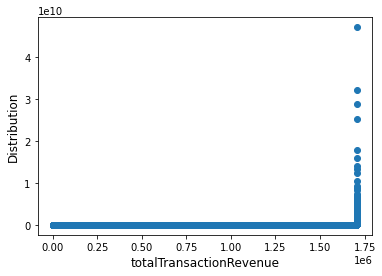

In [31]:
plt.scatter(range(train_clean.shape[0]), np.sort(train_clean['totals.totalTransactionRevenue'].values))
plt.xlabel('totalTransactionRevenue', fontsize=12)
plt.ylabel('Distribution', fontsize=12)
plt.show()    

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


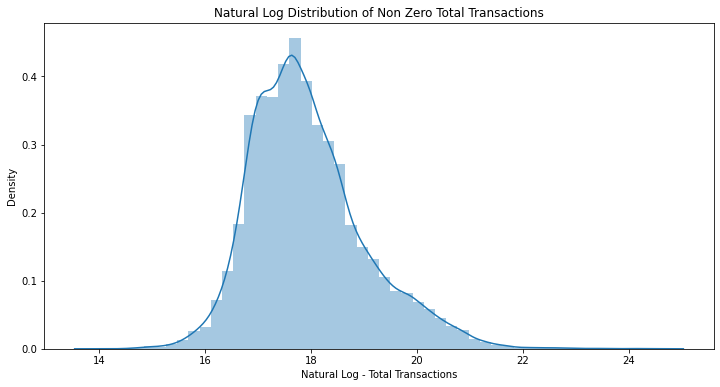

In [32]:
non_zero = train_clean[train_clean["totals.totalTransactionRevenue"] > 0]["totals.totalTransactionRevenue"]
plt.figure(figsize=(12,6))
sns.distplot(np.log1p(non_zero))
plt.title("Natural Log Distribution of Non Zero Total Transactions");
plt.xlabel("Natural Log - Total Transactions");

In [33]:
#skewness and kurtosis
print("Skewness: %f" % train_clean["totals.totalTransactionRevenue"].skew())
print("Kurtosis: %f" % train_clean["totals.totalTransactionRevenue"].kurt())

Skewness: 365.159632
Kurtosis: 193269.961454


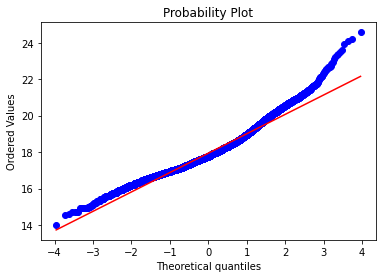

In [34]:
#Q-Q plot for checking if trip-times is log-normal
fig = plt.figure()
res = stats.probplot(np.log1p(non_zero), plot=plt)

From the above output for target variable,we observe

-  field deviates from the normal distribution.
-  Has appreciable positive skewness.
-  Show peakedness.   
-  Target field follows log normal distribution
 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.totalTransactionRevenue'>

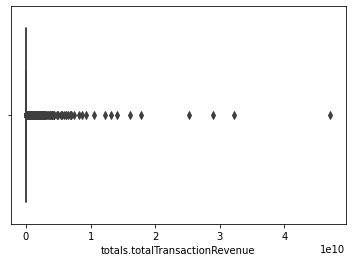

In [35]:
sns.boxplot("totals.totalTransactionRevenue",  data=train_clean)

In [36]:
for i in range(0,100,10):
    var =train_clean["totals.totalTransactionRevenue"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 0.0
70 percentile value is 0.0
80 percentile value is 0.0
90 percentile value is 0.0
100 percentile value is  47082060000.0


In [37]:
for i in range(90,100,1):
    var =train_clean["totals.totalTransactionRevenue"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 0.0
91 percentile value is 0.0
92 percentile value is 0.0
93 percentile value is 0.0
94 percentile value is 0.0
95 percentile value is 0.0
96 percentile value is 0.0
97 percentile value is 0.0
98 percentile value is 0.0
99 percentile value is 16990000.0
100 percentile value is  47082060000.0


In [38]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.totalTransactionRevenue"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 16990000.0
99.1 percentile value is 23200000.0
99.2 percentile value is 29600000.0
99.3 percentile value is 37890000.0
99.4 percentile value is 46790000.0
99.5 percentile value is 58460000.0
99.6 percentile value is 73980000.0
99.7 percentile value is 100010000.0
99.8 percentile value is 147970000.0
99.9 percentile value is 300570000.0
100 percentile value is  47082060000.0


In [29]:
train_clean[train_clean["totals.totalTransactionRevenue"]>300570000.0]["totals.totalTransactionRevenue"].count()

1708

#### field
totals.totalTransactionRevenue: total Transaction Revenue

#### Observation
From the above it is observed that in field "totals.totalTransactionRevenue" 99% of values is less than 16990000.0. and 99.9 of values is less than 300570000.0. There are roughly 1700 values with greater than 300570000.0


###   3.4.2    Analysis of independent variables

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='visitId'>

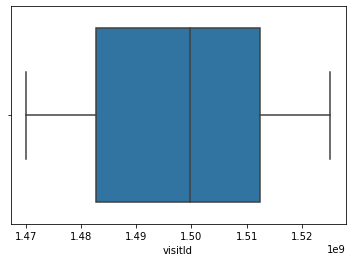

In [39]:
sns.boxplot("visitId",  data=train_clean)

#### field
 visitId - An identifier for this session.

#### Observation
 There is no other business information

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='visitNumber'>

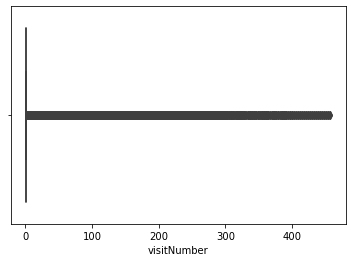

In [40]:
sns.boxplot("visitNumber",  data=train_clean)

In [41]:
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3200/data-cleaning-fare/7/module-6-machine-learning-real-world-case-studies

for i in range(0,100,10):
    var =train_clean["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 1
70 percentile value is 1
80 percentile value is 2
90 percentile value is 3
100 percentile value is  457


In [42]:
for i in range(90,100,1):
    var =train_clean["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 3
91 percentile value is 3
92 percentile value is 4
93 percentile value is 4
94 percentile value is 5
95 percentile value is 6
96 percentile value is 7
97 percentile value is 8
98 percentile value is 12
99 percentile value is 22
100 percentile value is  457


In [43]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["visitNumber"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 22
99.1 percentile value is 24
99.2 percentile value is 27
99.3 percentile value is 30
99.4 percentile value is 35
99.5 percentile value is 42
99.6 percentile value is 53
99.7 percentile value is 69
99.8 percentile value is 98
99.9 percentile value is 145
100 percentile value is  457


In [44]:
train_clean[train_clean["visitNumber"]>150]["visitNumber"].count()

1559

#### field
visitNumber - The session number for this user. If this is the first session, then this is set to 1.

#### Observation
From the above it is observed that in field "visitNumber" 99% of values is less than 22.
and 99.9 of values is less than 145.There are roughly 0.01 %   values with greater than 1500

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.hits'>

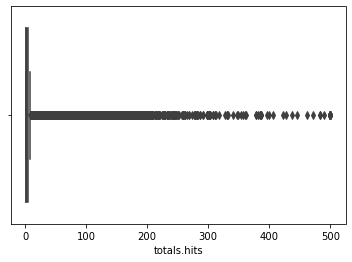

In [45]:
sns.boxplot("totals.hits",  data=train_clean)

In [46]:
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3200/data-cleaning-fare/7/module-6-machine-learning-real-world-case-studies
for i in range(0,100,10):
    var =train_clean["totals.hits"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 1
10 percentile value is 1
20 percentile value is 1
30 percentile value is 1
40 percentile value is 1
50 percentile value is 1
60 percentile value is 2
70 percentile value is 3
80 percentile value is 5
90 percentile value is 10
100 percentile value is  500


In [47]:
for i in range(90,100,1):
    var =train_clean["totals.hits"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 10
91 percentile value is 11
92 percentile value is 12
93 percentile value is 14
94 percentile value is 15
95 percentile value is 17
96 percentile value is 20
97 percentile value is 24
98 percentile value is 30
99 percentile value is 41
100 percentile value is  500


In [48]:
train_clean[train_clean["totals.hits"]>41]["totals.hits"].count()

16964

In [49]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.hits"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 41
99.1 percentile value is 43
99.2 percentile value is 46
99.3 percentile value is 48
99.4 percentile value is 51
99.5 percentile value is 55
99.6 percentile value is 61
99.7 percentile value is 67
99.8 percentile value is 77
99.9 percentile value is 97
100 percentile value is  500


#### field
totals.hits: Total number of hits within the session.

#### Observation
From the above it is observed that in field "totals.hits" 99% of values is less than 41.
and 99.9 of values is less than 97.There are roughly 1700  values with greater than 97

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.pageviews'>

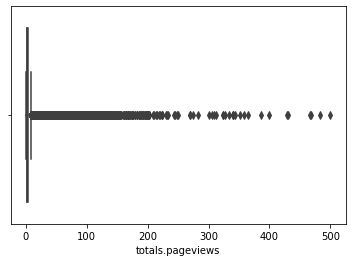

In [50]:
sns.boxplot("totals.pageviews",  data=train_clean)

In [51]:
##https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3200/data-cleaning-fare/7/module-6-machine-learning-real-world-case-studies
for i in range(0,100,10):
    var =train_clean["totals.pageviews"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 1.0
20 percentile value is 1.0
30 percentile value is 1.0
40 percentile value is 1.0
50 percentile value is 1.0
60 percentile value is 2.0
70 percentile value is 3.0
80 percentile value is 5.0
90 percentile value is 9.0
100 percentile value is  500.0


In [52]:
for i in range(90,100,1):
    var =train_clean["totals.pageviews"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 9.0
91 percentile value is 9.0
92 percentile value is 10.0
93 percentile value is 11.0
94 percentile value is 12.0
95 percentile value is 14.0
96 percentile value is 16.0
97 percentile value is 18.0
98 percentile value is 22.0
99 percentile value is 30.0
100 percentile value is  500.0


In [53]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.pageviews"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 30.0
99.1 percentile value is 32.0
99.2 percentile value is 33.0
99.3 percentile value is 35.0
99.4 percentile value is 37.0
99.5 percentile value is 40.0
99.6 percentile value is 43.0
99.7 percentile value is 47.0
99.8 percentile value is 54.0
99.9 percentile value is 67.0
100 percentile value is  500.0


In [54]:
train_clean[train_clean["totals.pageviews"]>67]["totals.hits"].count()

1648

#### field
totals.pageviews: Total number of pageviews within the session.

#### Observation
From the above it is observed that in field "totals.hits" 99% of values is less than 30. and 99.9 of values is less than 67. There are roughly 1600 values with greater than 67

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.sessionQualityDim'>

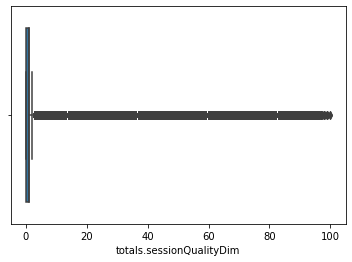

In [55]:
sns.boxplot("totals.sessionQualityDim",  data=train_clean)

In [56]:
for i in range(0,100,10):
    var =train_clean["totals.sessionQualityDim"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 1.0
60 percentile value is 1.0
70 percentile value is 1.0
80 percentile value is 1.0
90 percentile value is 1.0
100 percentile value is  100.0


In [57]:
for i in range(90,100,1):
    var =train_clean["totals.sessionQualityDim"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 1.0
91 percentile value is 2.0
92 percentile value is 2.0
93 percentile value is 2.0
94 percentile value is 3.0
95 percentile value is 4.0
96 percentile value is 6.0
97 percentile value is 11.0
98 percentile value is 26.0
99 percentile value is 55.0
100 percentile value is  100.0


In [58]:
#https://www.appliedaicourse.com/lecture/11/applied-machine-learning-online-course/3200/data-cleaning-fare/7/module-6-machine-learning-real-world-case-studies
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.sessionQualityDim"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 55.0
99.1 percentile value is 58.0
99.2 percentile value is 61.0
99.3 percentile value is 65.0
99.4 percentile value is 68.0
99.5 percentile value is 71.0
99.6 percentile value is 75.0
99.7 percentile value is 78.0
99.8 percentile value is 82.0
99.9 percentile value is 86.0
100 percentile value is  100.0


In [59]:
train_clean[train_clean["totals.sessionQualityDim"]>86]["totals.sessionQualityDim"].count()

1620

#### field
totals.sessionQualityDim: Estimate of how close session was to transacting.range[1,100]

#### Observation
From the above it is observed that in field "totals.sessionQualityDim" 99% of values is less than 55. and 99.9 of values is less than 86. There are roughly 1600 values with greater than 86

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.timeOnSite'>

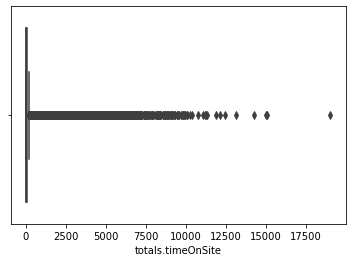

In [60]:
sns.boxplot("totals.timeOnSite",  data=train_clean)

In [61]:
for i in range(0,100,10):
    var =train_clean["totals.timeOnSite"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 21.0
70 percentile value is 53.0
80 percentile value is 115.0
90 percentile value is 317.0
100 percentile value is  19017.0


In [62]:
for i in range(90,100,1):
    var =train_clean["totals.timeOnSite"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 317.0
91 percentile value is 360.0
92 percentile value is 414.0
93 percentile value is 480.0
94 percentile value is 565.0
95 percentile value is 675.0
96 percentile value is 825.0
97 percentile value is 1028.0
98 percentile value is 1320.0
99 percentile value is 1757.0
100 percentile value is  19017.0


In [63]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.timeOnSite"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 1757.0
99.1 percentile value is 1814.0
99.2 percentile value is 1885.0
99.3 percentile value is 1976.0
99.4 percentile value is 2090.0
99.5 percentile value is 2225.0
99.6 percentile value is 2399.0
99.7 percentile value is 2626.0
99.8 percentile value is 2972.0
99.9 percentile value is 3609.0
100 percentile value is  19017.0


In [64]:
train_clean[train_clean["totals.timeOnSite"]>3609] ["totals.timeOnSite"].count()

1708

#### field
totals.timeOnSite: Total time of session in seconds.

#### Observation
From the above it is observed that in field "totals.timeOnSite" 99% of values is less than 1575. and 99.9 of values is less than 3609. There are roughly 1700 values with greater than 3609

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.transactions'>

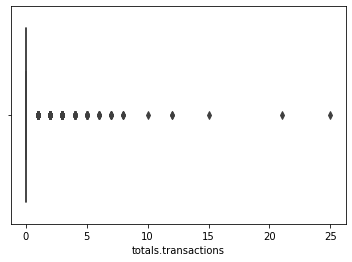

In [65]:
sns.boxplot("totals.transactions",  data=train_clean)

In [66]:
for i in range(0,100,10):
    var =train_clean["totals.transactions"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 0.0
70 percentile value is 0.0
80 percentile value is 0.0
90 percentile value is 0.0
100 percentile value is  25.0


In [67]:
for i in range(90,100,1):
    var =train_clean["totals.transactions"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 0.0
91 percentile value is 0.0
92 percentile value is 0.0
93 percentile value is 0.0
94 percentile value is 0.0
95 percentile value is 0.0
96 percentile value is 0.0
97 percentile value is 0.0
98 percentile value is 0.0
99 percentile value is 1.0
100 percentile value is  25.0


In [68]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.transactions"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 1.0
99.1 percentile value is 1.0
99.2 percentile value is 1.0
99.3 percentile value is 1.0
99.4 percentile value is 1.0
99.5 percentile value is 1.0
99.6 percentile value is 1.0
99.7 percentile value is 1.0
99.8 percentile value is 1.0
99.9 percentile value is 1.0
100 percentile value is  25.0


In [69]:
train_clean[train_clean["totals.transactions"]>1]["totals.transactions"].count()

511

#### field
totals.transactions: no. of transactions within session.

#### Observation
From the above it is observed that in field "totals.transactions" 99% of values is less than 1. and 99.9 of values is less than 1. There are roughly 511 values with greater than 1

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='totals.transactionRevenue'>

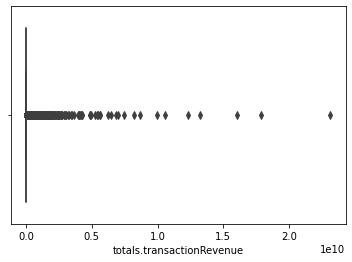

In [70]:
sns.boxplot("totals.transactionRevenue",  data=train_clean)

In [71]:
for i in range(0,100,10):
    var =train_clean["totals.transactionRevenue"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 0.0
20 percentile value is 0.0
30 percentile value is 0.0
40 percentile value is 0.0
50 percentile value is 0.0
60 percentile value is 0.0
70 percentile value is 0.0
80 percentile value is 0.0
90 percentile value is 0.0
100 percentile value is  23129500000.0


In [72]:
for i in range(90,100,1):
    var =train_clean["totals.transactionRevenue"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 0.0
91 percentile value is 0.0
92 percentile value is 0.0
93 percentile value is 0.0
94 percentile value is 0.0
95 percentile value is 0.0
96 percentile value is 0.0
97 percentile value is 0.0
98 percentile value is 0.0
99 percentile value is 12310000.0
100 percentile value is  23129500000.0


In [73]:
for i in np.arange(0.0, 1.0, 0.1):
    var =train_clean["totals.transactionRevenue"].values
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 12310000.0
99.1 percentile value is 18270000.0
99.2 percentile value is 23990000.0
99.3 percentile value is 32780000.0
99.4 percentile value is 40950000.0
99.5 percentile value is 51990000.0
99.6 percentile value is 67180000.0
99.7 percentile value is 91700000.0
99.8 percentile value is 137720000.0
99.9 percentile value is 277530000.0
100 percentile value is  23129500000.0


In [74]:
train_clean[train_clean["totals.transactionRevenue"]>277530000.0]["totals.transactionRevenue"].count()

1708

#### field
totals.transactionRevenue: decprecated 

#### Observation
use totals.totalTransactionRevenue


###  3.5  Univariate analysis for Categorical Variables

In [76]:
for col in train_clean.columns:
    if train_clean[col].dtypes == 'object':
        print(col)

channelGrouping
date
fullVisitorId
device.browser
device.operatingSystem
device.deviceCategory
geoNetwork.continent
geoNetwork.subContinent
geoNetwork.country
geoNetwork.region
geoNetwork.metro
geoNetwork.city
geoNetwork.networkDomain
trafficSource.campaign
trafficSource.source
trafficSource.medium
trafficSource.keyword
trafficSource.referralPath


Text(0.5, 1.0, 'Count of channelGrouping')

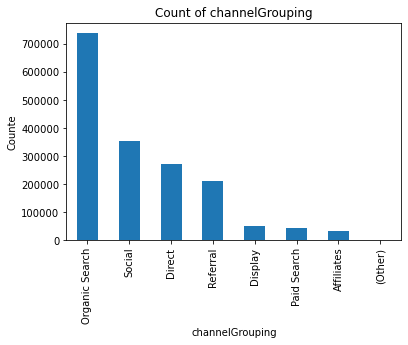

In [77]:
train_clean['channelGrouping'].value_counts().plot(kind='bar')
plt.xlabel("channelGrouping")
plt.ylabel("Counte")
plt.title("Count of channelGrouping")

#### field
channelGrouping: Channel from which user came to store

#### Observation
top three values are 
-  Organic-Search
-  Social
-  Direct


Text(0.5, 1.0, 'Count of device.operatingSystem')

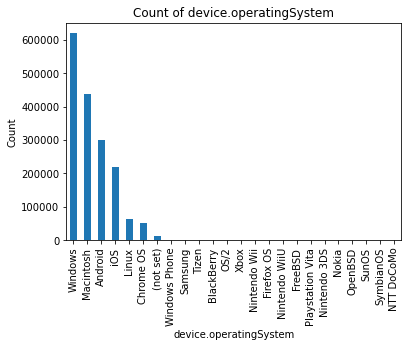

In [78]:
train_clean['device.operatingSystem'].value_counts().plot(kind='bar')
plt.xlabel("device.operatingSystem")
plt.ylabel("Count")
plt.title("Count of device.operatingSystem")

#### field
device.operatingSystem: Operating system of device

#### Observation
top three values are 
-  Windows
-  Macintosh
-  Andriod


Text(0.5, 1.0, 'Count of device.deviceCategory')

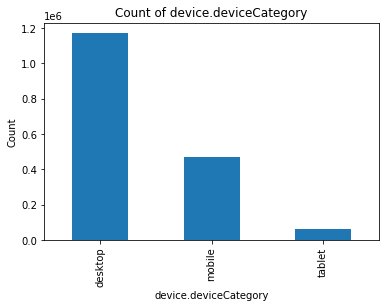

In [79]:
train_clean['device.deviceCategory'].value_counts().plot(kind='bar')
plt.xlabel("device.deviceCategory")
plt.ylabel("Count")
plt.title("Count of device.deviceCategory")

#### field
device.deviceCategory: type of device

#### Observation
top three values are 
-  desktop
-  mobile
-  tablet


Text(0.5, 1.0, 'Count of geoNetwork.continent')

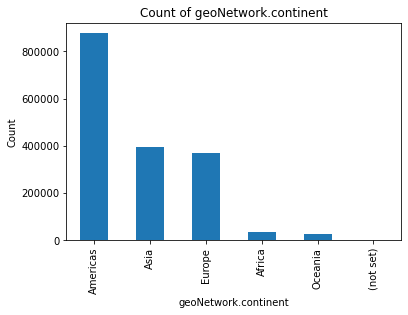

In [80]:
train_clean['geoNetwork.continent'].value_counts().plot(kind='bar')
plt.xlabel("geoNetwork.continent")
plt.ylabel("Count")
plt.title("Count of geoNetwork.continent")

#### field
geoNetwork.continent: continent where session originated

#### Observation
top three values are 
-  america
-  asia
-  europe


Text(0.5, 1.0, 'Count of geoNetwork.subContinent')

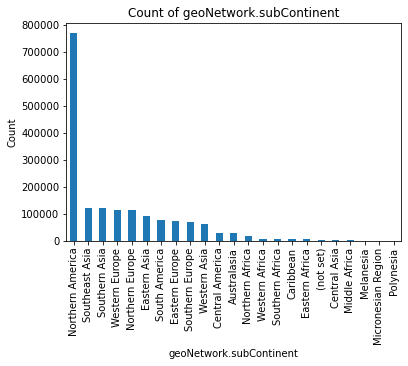

In [81]:
train_clean['geoNetwork.subContinent'].value_counts().plot(kind='bar')
plt.xlabel("geoNetwork.subContinent")
plt.ylabel("Count")
plt.title("Count of geoNetwork.subContinent")

#### field
geoNetwork.subContinent: subContinent where session originated

#### Observation
top three values are 
-  North america
-  South East Asia
-  South Asia


In [82]:
 #https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('geoNetwork.country').size().nlargest(5)

geoNetwork.country
United States     717217
India             105317
United Kingdom     73341
Canada             51057
Germany            38516
dtype: int64

#### field
geoNetwork.country: country where session originated

#### Observation
top three values are 
- United States 
-  India
-  United Kingdom


In [83]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('geoNetwork.region').size().nlargest(5)

geoNetwork.region
not available in demo dataset    932959
California                       206669
(not set)                         49774
New York                          49733
England                           25824
dtype: int64

#### field
geoNetwork.region: region where session originated

#### Observation
top three values are 
- California
- New York 
-  England


In [84]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.campaign').size().nlargest(5)

trafficSource.campaign
(not set)                                                 1604526
Data Share Promo                                            32914
1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS      24410
1000557 | GA | US | en | Hybrid | GDN Remarketing           15149
AW - Dynamic Search Ads Whole Site                          15146
dtype: int64

#### field
trafficSource.campaign: campaign value.set by utm campaign URL parameter

#### Observation
top three values are 
- Data Share Promo 
- 1000557 | GA | US | en | Hybrid | GDN Text+Banner | AS 
- 1000557 | GA | US | en | Hybrid | GDN Remarketing 


In [85]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.source').size().nlargest(5)

trafficSource.source
google                  658384
(direct)                565975
youtube.com             329450
analytics.google.com     37436
Partners                 32931
dtype: int64

#### field
trafficSource.source: source of traffic

#### Observation
top three values are 
- google 
- (direct)  
- youtube.com 


In [86]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.medium').size().nlargest(5)

trafficSource.medium
organic      591783
(none)       565957
referral     432963
cpc           75603
affiliate     32915
dtype: int64

#### field
trafficSource.medium: medium of traffic source

#### Observation
top three values are 
- organic 
- referral
- cpc


In [87]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.keyword').size().nlargest(5)

trafficSource.keyword
(not provided)                     1621713
(User vertical targeting)            25918
(automatic matching)                 18464
6qEhsCssdK0z36ri                     10870
(Remarketing/Content targeting)       5826
dtype: int64

#### field
trafficSource.keyword: keyword of traffic source

#### Observation
top three values are 
- (not provided) 
- (User vertical targeting) 
- (automatic matching)      



In [88]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('trafficSource.referralPath').size().nlargest(5)

trafficSource.referralPath
                   1142073
/                   138293
/yt/about/           79163
/analytics/web/      33112
/yt/about/tr/        14600
dtype: int64

#### field
trafficSource.referralPath: if trafficSource medium is "referral". this is set to path of referrer.

#### Observation
top three values are 
- /  
- /yt/about/ 
- /analytics/web/       



In [92]:
#https://stackoverflow.com/questions/40454030/count-and-sort-with-pandas
train_clean.groupby('date').size().nlargest(5)

date
2017-12-12    9234
2017-12-13    9131
2017-10-04    5122
2017-09-20    4880
2016-11-28    4807
dtype: int64

#### field
date:  date on which user visited store

#### Observation
top three values are 
- 2017-12-12  
- 2017-12-13   
- 2017-10-04    



Top values for all Categorical Features

In [93]:
for col in train_clean.columns:
    if train_clean[col].dtypes == 'object':
       print(train_clean.groupby(col).size().nlargest(5))
       print('================================')

channelGrouping
Organic Search    738963
Social            354971
Direct            273134
Referral          211307
Display            51283
dtype: int64
date
2017-12-12    9234
2017-12-13    9131
2017-10-04    5122
2017-09-20    4880
2016-11-28    4807
dtype: int64
fullVisitorId
1957458976293878100    400
7282998257608986241    315
3884810646891698298    268
7477638593794484792    218
824839726118485274     218
dtype: int64
device.browser
Chrome               1173056
Safari                312165
Firefox                63845
Internet Explorer      35474
Android Webview        34266
dtype: int64
device.operatingSystem
Windows      619720
Macintosh    438514
Android      299386
iOS          219334
Linux         63971
dtype: int64
device.deviceCategory
desktop    1171579
mobile      471336
tablet       65422
dtype: int64
geoNetwork.continent
Americas    877403
Asia        396719
Europe      368037
Africa       35481
Oceania      28180
dtype: int64
geoNetwork.subContinent
Northern America 

### Conclusion
*For maximum benefit one needs to focus  on top 0.01 percentile for high value segment and top 10 percetile for top segment.     
For categorical features the focus should be top few values.*

<span style="color:blue">**It is observed that data is sparse since most points do not contibute.This aspect has to be handled in modelling the data.** </span>.

### 3.6 bivariate analysis

<AxesSubplot:>

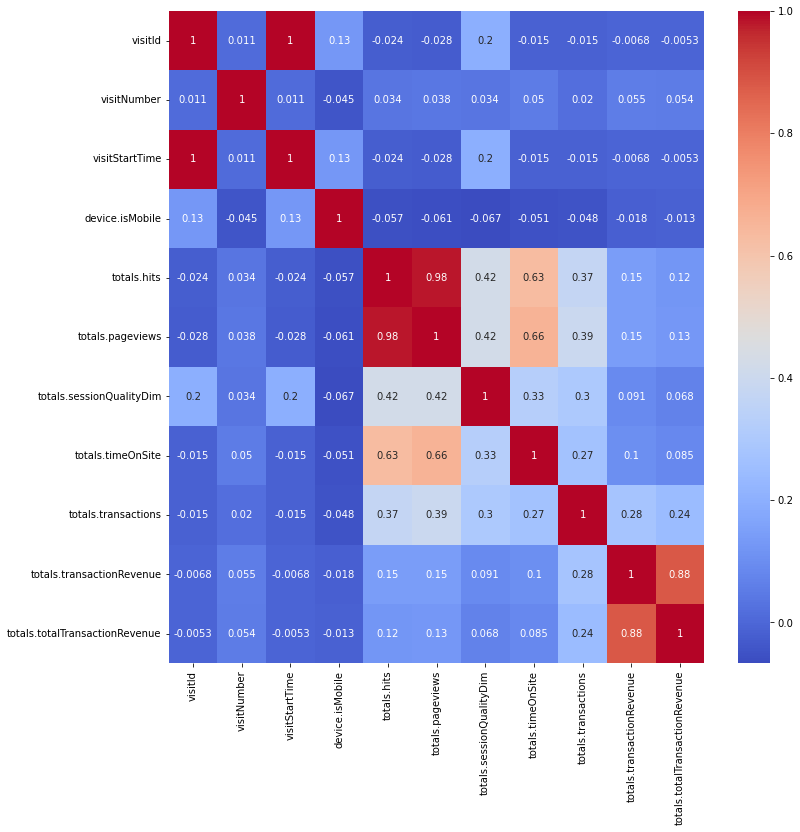

In [94]:
plt.figure(figsize=(12,12))
sns.heatmap(train_clean.corr(), annot = True,cmap='coolwarm')

### Conclusion
*Above output shows correlation between varaibles (total.pageviews, total.timeOnSite), (total.timeOnSite, total.hits) and (totals.transactionRevenue, totals.totaltransactionRevenue).*

###  3.7 Time Series Analysis

Create dataset indexed by time for time series analysis.

In [95]:
%%time
train_ts = pd.read_csv('train_fmt.csv', parse_dates=True, index_col = "date")

train_ts["year"] = train_ts.index.year
train_ts["month"] = train_ts.index.month

train_ts.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py:1324: DtypeWarning: Columns (2,57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 17 s, sys: 3.04 s, total: 20 s
Wall time: 20 s


,channelGrouping,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,...,trafficSource.isTrueDirect,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode,year,month
date,,,,,,,,,,,,,,,,,,,,,
2017-10-16,Organic Search,3162355547410993243,Not Socially Engaged,1508198450,1,1508198450,Firefox,not available in demo dataset,not available in demo dataset,Windows,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,10
2017-10-16,Referral,8934116514970143966,Not Socially Engaged,1508176307,6,1508176307,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,10
2017-10-16,Direct,7992466427990357681,Not Socially Engaged,1508201613,1,1508201613,Chrome,not available in demo dataset,not available in demo dataset,Android,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,10
2017-10-16,Organic Search,9075655783635761930,Not Socially Engaged,1508169851,1,1508169851,Chrome,not available in demo dataset,not available in demo dataset,Windows,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,10
2017-10-16,Organic Search,6960673291025684308,Not Socially Engaged,1508190552,1,1508190552,Chrome,not available in demo dataset,not available in demo dataset,Windows,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,10


<AxesSubplot:xlabel='date'>

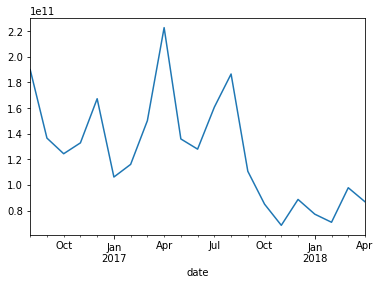

In [96]:
#  monthly plot of totalTransactionRevenue
train_ts['totals.totalTransactionRevenue'].resample('M').sum().plot()

####  Observation:
The plot shows peaks in moths of april,august 2017

<AxesSubplot:xlabel='date'>

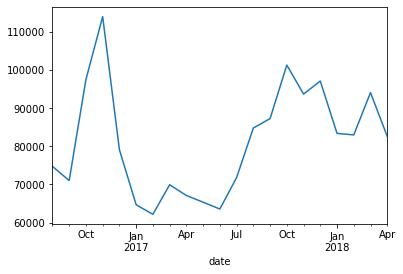

In [97]:
train_ts['totals.pageviews'].resample('M').count().plot()

####  Observation:
The plot shows peaks in month of december

<AxesSubplot:xlabel='date'>

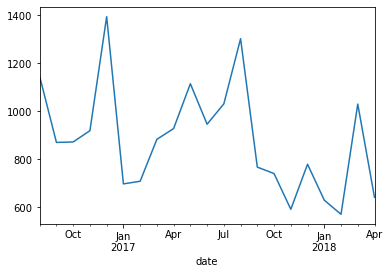

In [98]:
train_ts['totals.transactions'].resample('M').count().plot()

####  Observation:
The plot shows peaks in month of december,august

<AxesSubplot:xlabel='date'>

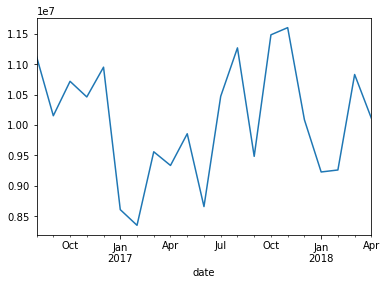

In [99]:
train_ts['totals.timeOnSite'].resample('M').sum().plot()

####  Observation:
The plot shows peaks in month of december,august

<AxesSubplot:xlabel='date'>

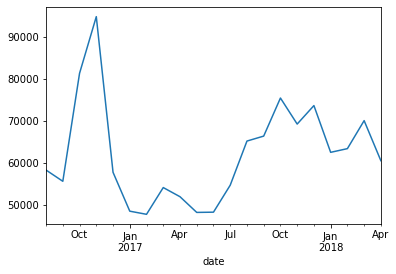

In [100]:
train_ts['totals.newVisits'].resample('M').count().plot()

####  Observation:
The plot shows peaks in month of december

###  Conclusion:
 <span style="color:blue">  The periods showing the peaks in time series have to utilised for more gains to the store. </span>

In [101]:
# settings to display all columns
pd.set_option("display.max_columns", None)
train_clean.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath
0,Organic Search,2017-10-16,3162355547410993243,1508198450,1,1508198450,Firefox,Windows,False,desktop,Europe,Western Europe,Germany,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),1,1.0,1.0,0.0,0.0,0.0,0.0,(not set),google,organic,water bottle,
1,Referral,2017-10-16,8934116514970143966,1508176307,6,1508176307,Chrome,Chrome OS,False,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Cupertino,(not set),2,2.0,2.0,28.0,0.0,0.0,0.0,(not set),sites.google.com,referral,(not provided),/a/google.com/transportation/mtv-services/bike...
2,Direct,2017-10-16,7992466427990357681,1508201613,1,1508201613,Chrome,Android,True,mobile,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,windjammercable.net,2,2.0,1.0,38.0,0.0,0.0,0.0,(not set),(direct),(none),(not provided),
3,Organic Search,2017-10-16,9075655783635761930,1508169851,1,1508169851,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,2,2.0,1.0,1.0,0.0,0.0,0.0,(not set),google,organic,(not provided),
4,Organic Search,2017-10-16,6960673291025684308,1508190552,1,1508190552,Chrome,Windows,False,desktop,Americas,Central America,Mexico,not available in demo dataset,not available in demo dataset,not available in demo dataset,prod-infinitum.com.mx,2,2.0,1.0,52.0,0.0,0.0,0.0,(not set),google,organic,(not provided),


##  4 Feature Engineering

###  4.1 create temporal features

In [22]:
#https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
def transform_date_int(indata):
    """
    Create temporal features from date fields
    """
    indata['date'] = pd.to_datetime(indata['date'])
    indata['dayofweek'] = indata['date'].dt.dayofweek 
    indata['quarter'] = indata['date'].dt.quarter 
    indata['month'] = indata['date'].dt.month 
    indata['year'] = indata['date'].dt.year 
    indata['dayofyear'] = indata['date'].dt.dayofyear 
    indata['dayofmonth'] = indata['date'].dt.day 
    indata['weekofyear'] = indata['date'].dt.isocalendar().week.astype(float)
    #features for visitStartTime
    indata['vis_date'] = pd.to_datetime(indata['visitStartTime'], unit='s')
    indata['sess_date_hours'] = indata['vis_date'].dt.hour 
    #https://www.kaggle.com/ashishpatel26/permutation-importance-feature-imp-measure-gacrp/notebook
    indata['hits_per_day']   = indata.groupby('dayofyear')['totals.hits'].transform('nunique') 
    indata['hits_per_month'] = indata.groupby('month')['totals.hits'].transform('nunique') 
    indata['hits_per_dom'] = indata.groupby('dayofmonth')['totals.hits'].transform('nunique') 
    indata['hits_per_dow'] = indata.groupby('dayofweek')['totals.hits'].transform('nunique') 
    indata['pageviews_per_day'] = indata.groupby('dayofyear')['totals.pageviews'].transform('nunique') 
    indata['pageviews_per_month'] = indata.groupby('month')['totals.pageviews'].transform('nunique') 
    indata['pageviews_per_dom'] = indata.groupby('dayofmonth')['totals.pageviews'].transform('nunique') 
    indata['pageviews_per_dow'] = indata.groupby('dayofweek')['totals.pageviews'].transform('nunique') 
    indata['month_unique_user_count'] = indata.groupby('month')['fullVisitorId'].transform('nunique')
    indata['day_unique_user_count'] = indata.groupby('dayofyear')['fullVisitorId'].transform('nunique')
    indata['weekday_unique_user_count'] = indata.groupby('dayofweek')['fullVisitorId'].transform('nunique')
    indata['monthday_unique_user_count'] = indata.groupby('dayofmonth')['fullVisitorId'].transform('nunique') 
    indata['browser_category'] = indata['device.browser'] + '_' + indata['device.deviceCategory']
    indata['browser_os'] = indata['device.browser'] + '_' + indata['device.operatingSystem']
    indata['source_country'] = indata['trafficSource.source'] + '_' + indata['geoNetwork.country']
    indata['channelGrouping_browser'] = indata['device.browser'] + "_" + indata['channelGrouping']
    indata['channelGrouping_OS'] = indata['device.operatingSystem'] + "_" + indata['channelGrouping']
    indata['tran_per_day']   = indata.groupby('dayofyear')['totals.transactions'].transform('nunique') 
    indata['tran_per_month'] = indata.groupby('month')['totals.transactions'].transform('nunique') 
    indata['tran_per_dom'] = indata.groupby('dayofmonth')['totals.transactions'].transform('nunique') 
    indata['tran_per_dow'] = indata.groupby('dayofweek')['totals.transactions'].transform('nunique') 
    indata['timeOnSite_per_day']   = indata.groupby('dayofyear')['totals.timeOnSite'].transform('nunique') 
    indata['timeOnSite_per_month'] = indata.groupby('month')['totals.timeOnSite'].transform('nunique') 
    indata['timeOnSite_per_dom'] = indata.groupby('dayofmonth')['totals.timeOnSite'].transform('nunique') 
    indata['timeOnSite_per_dow'] = indata.groupby('dayofweek')['totals.timeOnSite'].transform('nunique') 
    
    #convert int to float to avoid truncations
    for col in indata.columns:
        if indata[col].dtype == 'int64':   
           indata[col] = indata[col].astype(float)
    return indata

In [28]:
train_clean = transform_date_int(train_clean)

In [29]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1708337 entries, 0 to 1708336
Data columns (total 63 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   channelGrouping                 object        
 1   date                            datetime64[ns]
 2   fullVisitorId                   object        
 3   visitId                         float64       
 4   visitNumber                     float64       
 5   visitStartTime                  float64       
 6   device.browser                  object        
 7   device.operatingSystem          object        
 8   device.isMobile                 bool          
 9   device.deviceCategory           object        
 10  geoNetwork.continent            object        
 11  geoNetwork.subContinent         object        
 12  geoNetwork.country              object        
 13  geoNetwork.region               object        
 14  geoNetwork.metro                object        
 15

### 4.2 Encode Categorical features

In [30]:
# get list of categorical  columns
cat_cols=[]

for col in train_clean.columns:
    if train_clean[col].dtype == 'object':   
        cat_cols.append(col)

cat_cols.remove('fullVisitorId')  # remove field

Here Cardinality of Features is high so label encoding is used. One hot encoding will create a high dimesion data.

In [20]:
def transform_cat(indata):
    '''
    encode categorical features
    '''
    out_df =  pd.DataFrame()
    for col in cat_cols: 
        labelencoder = LabelEncoder()
        indata[col] = labelencoder.fit_transform(indata[col].values.astype('str' ))
     

In [32]:
transform_cat(train_clean)

In [33]:
# settings to display all columns
pd.set_option("display.max_columns", None)
train_clean.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.sessionQualityDim,totals.timeOnSite,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.referralPath,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,vis_date,sess_date_hours,hits_per_day,hits_per_month,hits_per_dom,hits_per_dow,pageviews_per_day,pageviews_per_month,pageviews_per_dom,pageviews_per_dow,month_unique_user_count,day_unique_user_count,weekday_unique_user_count,monthday_unique_user_count,browser_category,browser_os,source_country,channelGrouping_browser,channelGrouping_OS,tran_per_day,tran_per_month,tran_per_dom,tran_per_dow,timeOnSite_per_day,timeOnSite_per_month,timeOnSite_per_dom,timeOnSite_per_dow
0,4,2017-10-16,3162355547410993243,1.508198e+09,1.0,1.508198e+09,43,20,False,0,4,22,75,482,122,955,0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,4,99,5,3365,0,0.0,4.0,10.0,2017.0,289.0,16.0,42.0,2017-10-17 00:00:50,0.0,68.0,182.0,133.0,198.0,53.0,138.0,100.0,147.0,166107.0,5130.0,230864.0,52186.0,56,67,1716,93,102,3.0,8.0,5.0,7.0,658.0,2832.0,2048.0,3134.0
1,6,2017-10-16,8934116514970143966,1.508176e+09,6.0,1.508176e+09,35,3,False,0,2,12,218,73,100,220,0,2.0,2.0,2.0,28.0,0.0,0.0,0.0,4,301,6,7,301,0.0,4.0,10.0,2017.0,289.0,16.0,42.0,2017-10-16 17:51:47,17.0,68.0,182.0,133.0,198.0,53.0,138.0,100.0,147.0,166107.0,5130.0,230864.0,52186.0,42,39,3466,68,28,3.0,8.0,5.0,7.0,658.0,2832.0,2048.0,3134.0
2,2,2017-10-16,7992466427990357681,1.508202e+09,1.0,1.508202e+09,35,1,True,1,2,12,218,482,122,955,40939,2.0,2.0,1.0,38.0,0.0,0.0,0.0,4,0,0,7,0,0.0,4.0,10.0,2017.0,289.0,16.0,42.0,2017-10-17 00:53:33,0.0,68.0,182.0,133.0,198.0,53.0,138.0,100.0,147.0,166107.0,5130.0,230864.0,52186.0,43,37,206,64,10,3.0,8.0,5.0,7.0,658.0,2832.0,2048.0,3134.0
3,4,2017-10-16,9075655783635761930,1.508170e+09,1.0,1.508170e+09,35,20,False,0,3,21,210,482,122,955,38725,2.0,2.0,1.0,1.0,0.0,0.0,0.0,4,99,5,7,0,0.0,4.0,10.0,2017.0,289.0,16.0,42.0,2017-10-16 16:04:11,16.0,68.0,182.0,133.0,198.0,53.0,138.0,100.0,147.0,166107.0,5130.0,230864.0,52186.0,42,45,1842,66,102,3.0,8.0,5.0,7.0,658.0,2832.0,2048.0,3134.0
4,4,2017-10-16,6960673291025684308,1.508191e+09,1.0,1.508191e+09,35,20,False,0,2,3,132,482,122,955,29216,2.0,2.0,1.0,52.0,0.0,0.0,0.0,4,99,5,7,0,0.0,4.0,10.0,2017.0,289.0,16.0,42.0,2017-10-16 21:49:12,21.0,68.0,182.0,133.0,198.0,53.0,138.0,100.0,147.0,166107.0,5130.0,230864.0,52186.0,42,45,1770,66,102,3.0,8.0,5.0,7.0,658.0,2832.0,2048.0,3134.0


### 4.3 data transform

In [21]:
def data_transform(indata):
    '''
    transform user level features
    '''
    #https://stackoverflow.com/questions/19078325/naming-returned-columns-in-pandas-aggregate-function
    def diff(x):
      #get difference between max & min date  
      time_d =  x.max() -x.min() 
      return float(time_d.days)
    #https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values  
    def vcount(x):
      #get count of rows for visitStartTime
      return len(indata.loc[indata['visitStartTime'].isin(x)])
    #
    date_min= min(indata['date'])
    date_max= max(indata['date'])   
    # difference between preiod start and first visit
    def min_diff(x):
      time_d= x.min() - date_min
      return float(time_d.days)
    # difference between preiod end and last visit
    def max_diff(x):
      time_d=  date_max - x.max()
      return float(time_d.days)
        

    dfg=indata.groupby('fullVisitorId').agg({ 
    'channelGrouping'             : ['max'],              
    'device.browser'              : 'max',                   
    'device.operatingSystem'      : 'max',                     
    'device.isMobile'             : 'max',      
    'device.deviceCategory'       : 'max',                      
    'geoNetwork.continent'        : 'max',                      
    'geoNetwork.subContinent'     : 'max',                        
    'geoNetwork.country'          : 'max',                       
    'geoNetwork.region'           : 'max',                        
    'geoNetwork.metro'            : 'max',                          
    'geoNetwork.city'             : 'max',                         
    'geoNetwork.networkDomain'    : 'max',                          
    'trafficSource.campaign'      : 'max',                         
    'trafficSource.source'        : 'max',                          
    'trafficSource.medium'        : 'max',                         
    'trafficSource.keyword'       : 'max',                          
    'trafficSource.referralPath'  : 'max',                         
    'date'                      : [('_diff', diff),('_min',min_diff),('_max',max_diff)], 
    'visitStartTime'            : [('_count', vcount)],                    
    'totals.hits'               : [ 'max', 'min', 'sum','mean'],    
    'totals.pageviews'          : ['max', 'min', 'sum','mean'],
    'totals.timeOnSite'         : ['max', 'min', 'sum','mean'], 
    'totals.sessionQualityDim'  : 'max',
    'totals.transactions'       : 'sum',                
    'totals.transactionRevenue' : 'sum',               
    'totals.totalTransactionRevenue' :  'sum',
    'dayofweek'                 :  [ 'max', 'min'],                
    'quarter'                   :  [ 'max', 'min'],                                
    'month'                     :  [ 'max', 'min'],                                   
    'year'                      :  [ 'max', 'min'],                                 
    'dayofyear'                 :  [ 'max', 'min'],                                 
    'dayofmonth'                :  [ 'max', 'min'],                                   
    'weekofyear'                :  [ 'max', 'min'],      
    'sess_date_hours'           :  [ 'max', 'min', 'sum','mean'],
    'hits_per_day'              :  [ 'max', 'min', 'sum','mean'],   
    'hits_per_month'            :  [ 'max', 'min', 'sum','mean'],    
    'hits_per_dom'              :  [ 'max', 'min', 'sum','mean'],    
    'hits_per_dow'              :  [ 'max', 'min', 'sum','mean'],    
    'pageviews_per_day'         :  [ 'max', 'min', 'sum','mean'], 
    'pageviews_per_month'       :  [ 'max', 'min', 'sum','mean'], 
    'pageviews_per_dom'         :  [ 'max', 'min', 'sum','mean'], 
    'pageviews_per_dow'         :  [ 'max', 'min', 'sum','mean'], 
    'month_unique_user_count'   :  [ 'max', 'min', 'sum','mean'],    
    'day_unique_user_count'     :  [ 'max', 'min', 'sum','mean'],    
    'weekday_unique_user_count' :  [ 'max', 'min', 'sum','mean'],    
    'monthday_unique_user_count' :  [ 'max', 'min', 'sum','mean'],    
    'browser_category'          : 'max', 
    'browser_os'                : 'max',
    'source_country'            : 'max',   
    'channelGrouping_browser'   : 'max',   
    'channelGrouping_OS'        : 'max',   
    'tran_per_day'              :  [ 'max', 'min', 'sum','mean'],   
    'tran_per_month'            :  [ 'max', 'min', 'sum','mean'],  
    'tran_per_dom'              :  [ 'max', 'min', 'sum','mean'],  
    'tran_per_dow'              :  [ 'max', 'min', 'sum','mean'],  
    'timeOnSite_per_day'        :  [ 'max', 'min', 'sum','mean'],   
    'timeOnSite_per_month'      :  [ 'max', 'min', 'sum','mean'],  
    'timeOnSite_per_dom'        :  [ 'max', 'min', 'sum','mean'],  
    'timeOnSite_per_dow'        :  [ 'max', 'min', 'sum','mean']  
     
        
    })
    #rename column by appending the aggregate name
    dfg.columns = ["_".join(x) for x in dfg.columns.ravel()]
    return dfg

In [34]:
# source
#https://www.kaggle.com/kostoglot/winning-solution?scriptVersionId=10911396#L144    
#https://github.com/HuanZhang999/GoogleAnalyticsCustomerRevenuePrediction/blob/master/1-%20create_train.ipynb?utm_source=pocket_mylist  

def CreateTimeData(in_df,indate):
    '''
    create  time based data
    '''
    train_window = 168   # time window for train
    test_window = 62     # time window for test
    train_test_gap=46    # gap between train test
    #
    date_low = indate
    date_high = date_low + timedelta(train_window)
    train_ts = in_df.loc[(in_df['date']>= date_low)  & (in_df['date']<= date_high)]
    #
    date_low_test = date_low  + timedelta(train_window + train_test_gap)
    date_high_test = date_low  + timedelta(train_window + train_test_gap + test_window)
    test_ts = in_df.loc[(in_df['date']>= date_low_test)  & (in_df['date']<= date_high_test)]
    #
    #get common customers for train & test
    common  = pd.merge(train_ts,test_ts['fullVisitorId'].drop_duplicates(),how='inner')
    #
    #get non returning customers 
    nonret = pd.merge(train_ts['fullVisitorId'].drop_duplicates(), 
                      common['fullVisitorId'].drop_duplicates(),how='left',indicator=True)
    non2 = nonret[nonret['_merge'] == 'left_only'].drop('_merge',axis='columns')
    
    #
    #calculate revenue for customer
    cust_returned= test_ts.groupby('fullVisitorId')[['totals.totalTransactionRevenue']].sum().apply(
                   np.log1p, axis=1).reset_index()
    cust_returned.rename(columns = {'totals.totalTransactionRevenue':'revenue'}, inplace = True)   
    cust_returned['returned'] = 1
    #
    #create df for non returned customer 
    cust_not_returned = pd.DataFrame()
    cust_not_returned['fullVisitorId'] = non2['fullVisitorId']
    cust_not_returned['returned'] = 0
    cust_not_returned['revenue'] = 0
    #
    #combine returned & non returned customers
    cust_all = pd.concat([cust_returned, cust_not_returned], axis=0).reset_index(drop=True)
    #
    #add features to train
    train_format = data_transform(train_ts)
    #merge train, cust data
    final  = pd.merge(train_format,cust_all,left_on='fullVisitorId', right_on='fullVisitorId')
    return final

## 5 prepare data for time series

The test dataset provided has dates from 1-may-2018 to 15-oct-2018. The time window is 168 days. This time window can be used to create the train datasets for time series.
 
The prediction time frame is  1-dec-2018 to 31-jan-2019. The difference between the train and prediction dates is  46 days (  15-oct-2018,1-dec-2018 ). This gap is maintained between train and test for creation of test dataset for time series.
The prediction time window is  62 days. This window is used for test dataset.   
Customers present in both train and test are identified as common customers.

Using above criterion, we create 4 sets of data to train the prediction model.

Source:    
https://www.kaggle.com/c/ga-customer-revenue-prediction/discussion/82614       

In [14]:
date_low = min(train_clean['date'])
date_low

Timestamp('2016-08-01 00:00:00')

In [15]:
train_clean.shape

(1708337, 63)

In [16]:
%%time
train1 =  CreateTimeData(train_clean,date_low)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


CPU times: user 50min 33s, sys: 3.16 s, total: 50min 36s
Wall time: 50min 34s


In [17]:
pd.set_option('display.max_columns', None)
train1.head()

,fullVisitorId,channelGrouping_max,device.browser_max,device.operatingSystem_max,device.isMobile_max,device.deviceCategory_max,geoNetwork.continent_max,geoNetwork.subContinent_max,geoNetwork.country_max,geoNetwork.region_max,geoNetwork.metro_max,geoNetwork.city_max,geoNetwork.networkDomain_max,trafficSource.campaign_max,trafficSource.source_max,trafficSource.medium_max,trafficSource.keyword_max,trafficSource.referralPath_max,date__diff,date__min,date__max,visitStartTime__count,totals.hits_max,totals.hits_min,totals.hits_sum,totals.hits_mean,totals.pageviews_max,totals.pageviews_min,totals.pageviews_sum,totals.pageviews_mean,totals.timeOnSite_max,totals.timeOnSite_min,totals.timeOnSite_sum,totals.timeOnSite_mean,totals.sessionQualityDim_max,totals.transactions_sum,totals.transactionRevenue_sum,totals.totalTransactionRevenue_sum,dayofweek_max,dayofweek_min,quarter_max,quarter_min,month_max,month_min,year_max,year_min,dayofyear_max,dayofyear_min,dayofmonth_max,dayofmonth_min,weekofyear_max,weekofyear_min,sess_date_hours_max,sess_date_hours_min,sess_date_hours_sum,sess_date_hours_mean,hits_per_day_max,hits_per_day_min,hits_per_day_sum,hits_per_day_mean,hits_per_month_max,hits_per_month_min,hits_per_month_sum,hits_per_month_mean,hits_per_dom_max,hits_per_dom_min,hits_per_dom_sum,hits_per_dom_mean,hits_per_dow_max,hits_per_dow_min,hits_per_dow_sum,hits_per_dow_mean,pageviews_per_day_max,pageviews_per_day_min,pageviews_per_day_sum,pageviews_per_day_mean,pageviews_per_month_max,pageviews_per_month_min,pageviews_per_month_sum,pageviews_per_month_mean,pageviews_per_dom_max,pageviews_per_dom_min,pageviews_per_dom_sum,pageviews_per_dom_mean,pageviews_per_dow_max,pageviews_per_dow_min,pageviews_per_dow_sum,pageviews_per_dow_mean,month_unique_user_count_max,month_unique_user_count_min,month_unique_user_count_sum,month_unique_user_count_mean,day_unique_user_count_max,day_unique_user_count_min,day_unique_user_count_sum,day_unique_user_count_mean,weekday_unique_user_count_max,weekday_unique_user_count_min,weekday_unique_user_count_sum,weekday_unique_user_count_mean,monthday_unique_user_count_max,monthday_unique_user_count_min,monthday_unique_user_count_sum,monthday_unique_user_count_mean,browser_category_max,browser_os_max,source_country_max,channelGrouping_browser_max,channelGrouping_OS_max,tran_per_day_max,tran_per_day_min,tran_per_day_sum,tran_per_day_mean,tran_per_month_max,tran_per_month_min,tran_per_month_sum,tran_per_month_mean,tran_per_dom_max,tran_per_dom_min,tran_per_dom_sum,tran_per_dom_mean,tran_per_dow_max,tran_per_dow_min,tran_per_dow_sum,tran_per_dow_mean,timeOnSite_per_day_max,timeOnSite_per_day_min,timeOnSite_per_day_sum,timeOnSite_per_day_mean,timeOnSite_per_month_max,timeOnSite_per_month_min,timeOnSite_per_month_sum,timeOnSite_per_month_mean,timeOnSite_per_dom_max,timeOnSite_per_dom_min,timeOnSite_per_dom_sum,timeOnSite_per_dom_mean,timeOnSite_per_dow_max,timeOnSite_per_dow_min,timeOnSite_per_dow_sum,timeOnSite_per_dow_mean,revenue,returned
0,0000500012543476818,6,35,7,False,0,2,12,218,73,100,829,31811,4,0,0,7,1,0.0,143.0,25.0,1,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,34.0,34.0,34.0,34.0,0.0,0.0,0.0,0.0,3.0,3.0,4.0,4.0,12.0,12.0,2016.0,2016.0,357.0,357.0,22.0,22.0,51.0,51.0,3.0,3.0,3.0,3.0,68.0,68.0,68.0,68.0,168.0,168.0,168.0,168.0,130.0,130.0,130.0,130.0,191.0,191.0,191.0,191.0,55.0,55.0,55.0,55.0,129.0,129.0,129.0,129.0,100.0,100.0,100.0,100.0,146.0,146.0,146.0,146.0,143543.0,143543.0,143543.0,143543.0,3815.0,3815.0,3815.0,3815.0,235209.0,235209.0,235209.0,235209.0,50772.0,50772.0,50772.0,50772.0,42,42,206,68,54,2.0,2.0,2.0,2.0,6.0,6.0,6.0,6.0,4.0,4.0,4.0,4.0,9.0,9.0,9.0,9.0,583.0,583.0,583.0,583.0,2798.0,2798.0,2798.0,2798.0,2013.0,2013.0,2013.0,2013.0,3168.0,3168.0,3168.0,3168.0,0.0,0
1,000084172700693338,7,35,1,True,1,3,6,183,482,122,955,38725,4,343,6,7,2646,0.0,126.0,42.0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,12.0,12.0,2016.0,2016.0,340.0,340.0,5.0,5.0,49.0,49.0,4.0,4.0,4.0,4.0,84.0

In [18]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379708 entries, 0 to 379707
Columns: 143 entries, fullVisitorId to returned
dtypes: bool(1), float64(118), int64(23), object(1)
memory usage: 414.6+ MB


In [19]:
train1.shape

(379708, 143)

In [20]:
train1.to_pickle('train1')

In [21]:
#increment date by time window of 168 days
date_low = date_low + timedelta(168)
date_low

Timestamp('2017-01-16 00:00:00')

In [22]:
%%time
train2 =  CreateTimeData(train_clean,date_low)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


CPU times: user 31min 36s, sys: 250 ms, total: 31min 36s
Wall time: 31min 37s


In [23]:
train2.to_pickle('train2')

In [24]:
train2.shape

(291233, 143)

In [25]:
#increment date by time window of 168 days
date_low = date_low + timedelta(168)
date_low

Timestamp('2017-07-03 00:00:00')

In [26]:
%%time
train3 =  CreateTimeData(train_clean,date_low)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


CPU times: user 56min 17s, sys: 3.01 s, total: 56min 20s
Wall time: 56min 17s


In [27]:
train3.to_pickle('train3')

In [28]:
train3.shape

(389581, 143)

In [29]:
#increment date by time window of 168 days
date_low = date_low + timedelta(168)
date_low

Timestamp('2017-12-18 00:00:00')

In [30]:
%%time
train4 =  CreateTimeData(train_clean,date_low)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


CPU times: user 32min 40s, sys: 1.96 s, total: 32min 42s
Wall time: 32min 40s


In [31]:
train4.to_pickle('train4')

In [32]:
train4.shape

(294330, 143)

### 5.1 Find Feature Importance

In [33]:
train_tot = pd.concat([train1, train2, train3, train4 ], axis=0, sort=False).reset_index(drop=True)

In [34]:
feature_lst =  list(train_tot.columns)
feature_lst.remove('totals.totalTransactionRevenue_sum')
feature_lst.remove('revenue')

In [35]:
#source
# https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

reg = xgb.XGBRegressor(n_estimators=1000)
 

In [36]:
train_tot['fullVisitorId']= train_tot['fullVisitorId'].astype('float')

In [37]:
%%time
reg.fit(train_tot[feature_lst], train_tot['revenue'])

CPU times: user 5h 40min 45s, sys: 11.3 s, total: 5h 40min 57s
Wall time: 1h 25min 35s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [43]:
reg.save_model('reg_fi')

In [47]:
results=pd.DataFrame()
results['columns']=feature_lst
results['importances'] = reg.feature_importances_
results.sort_values(by='importances',ascending=False,inplace=True)

In [51]:
results.to_csv('result_fi')

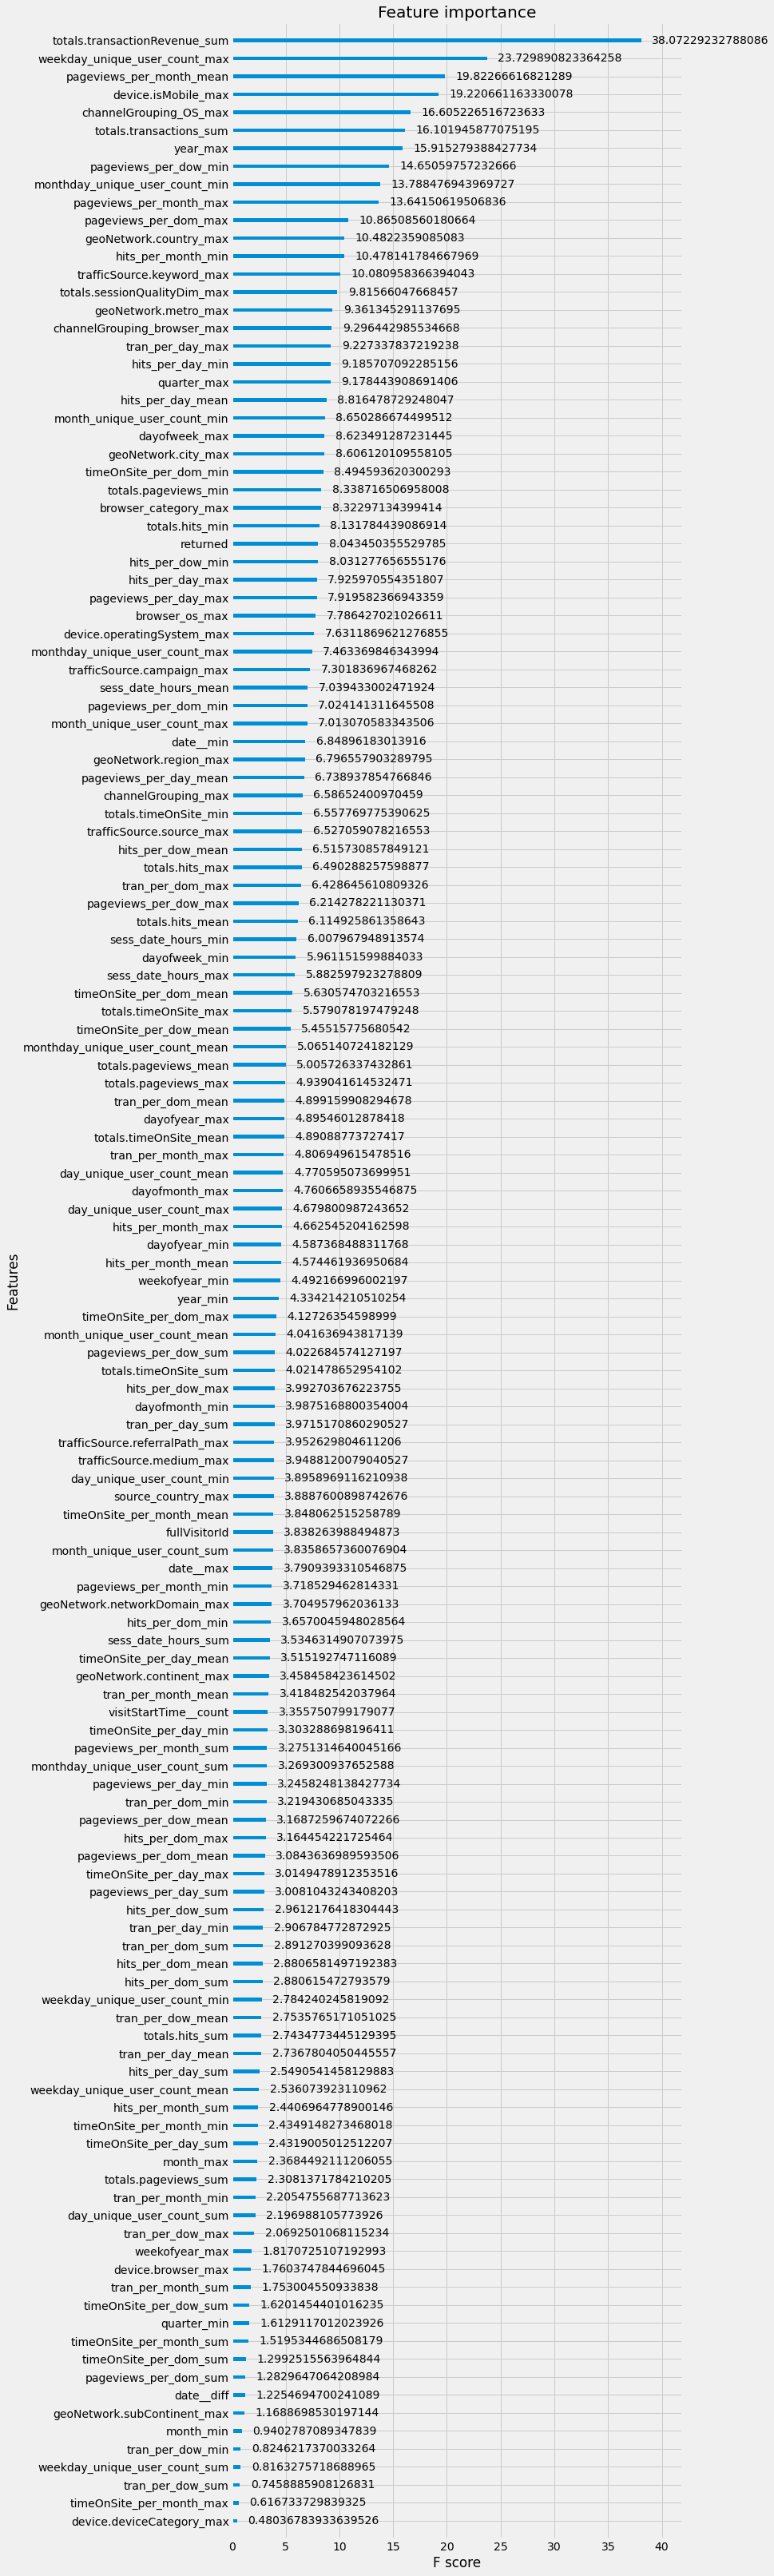

In [41]:
#https://stackoverflow.com/questions/51546340/how-to-enlarge-xgbclassifier-plot-importance-size-in-jupyter
ax = plot_importance(reg,max_num_features=144, importance_type='gain')
ax.figure.set_size_inches(9,54)

For Time Series Based problems in addition to Domain Features. Temporal features are required for models to pick patterns from temporal features.  

### 5.2 Prepare test data

In [5]:
%%time
# load test data 
test_fmt = load_file("test_v2.csv",json_columns) 
test_fmt.head()

CPU times: user 50.9 s, sys: 5.13 s, total: 56 s
Wall time: 1min 27s


,channelGrouping,date,fullVisitorId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,...,trafficSource.medium,trafficSource.keyword,trafficSource.adContent,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd
0,Organic Search,20180511,7460955084541987166,Not Socially Engaged,1526099341,2,1526099341,Chrome,not available in demo dataset,not available in demo dataset,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
1,Direct,20180511,460252456180441002,Not Socially Engaged,1526064483,166,1526064483,Chrome,not available in demo dataset,not available in demo dataset,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20180511,3461808543879602873,Not Socially Engaged,1526067157,2,1526067157,Chrome,not available in demo dataset,not available in demo dataset,...,organic,(not provided),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
3,Direct,20180511,975129477712150630,Not Socially Engaged,1526107551,4,1526107551,Chrome,not available in demo dataset,not available in demo dataset,...,(none),(not set),(not set),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20180511,8381672768065729990,Not Socially Engaged,1526060254,1,1526060254,Internet Explorer,not available in demo dataset,not available in demo dataset,...,organic,(not provided),(not set),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN


In [6]:
#shape of test dataframe
test_fmt.shape

(401589, 57)

In [7]:
#remove all columns dropped from train 
remove_cols= ['totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd',
 'trafficSource.campaignCode',
 'trafficSource.adContent',
 'trafficSource.adwordsClickInfo.slot',
 'trafficSource.adwordsClickInfo.adNetworkType',
 'trafficSource.adwordsClickInfo.gclId',
 'trafficSource.adwordsClickInfo.page']

In [8]:
remove_cols.remove('trafficSource.campaignCode') #remove missing column in test

In [9]:
# remove unwanted features from dataframe
test_clean = test_fmt.drop(remove_cols, axis=1) 

# shape after removing unwanted features from dataframe
test_clean.shape

(401589, 29)

In [10]:
#change date to pandas format
#test_clean['date']= pd.to_datetime(test_clean['date'],format='%Y%m%d')
# save flattened data to file 
test_clean.to_csv('test_clean.csv',index=False)

In [11]:
%%time
#load cleaned file for EDA
#Important : fullVisitorId should be loaded as "str"
test_clean = pd.read_csv('test_clean.csv',converters={"fullVisitorId": str}) # read cleaned file 
test_clean.head()

CPU times: user 1.68 s, sys: 18.7 ms, total: 1.7 s
Wall time: 1.7 s


,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.timeOnSite,totals.sessionQualityDim,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20180511,7460955084541987166,1526099341,2,1526099341,Chrome,Android,True,mobile,...,973.0,1,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided)
1,Direct,20180511,460252456180441002,1526064483,166,1526064483,Chrome,Macintosh,False,desktop,...,49.0,1,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set)
2,Organic Search,20180511,3461808543879602873,1526067157,2,1526067157,Chrome,Chrome OS,False,desktop,...,24.0,1,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided)
3,Direct,20180511,975129477712150630,1526107551,4,1526107551,Chrome,iOS,True,mobile,...,25.0,1,NaN,NaN,NaN,(not set),(not set),(direct),(none),(not set)
4,Organic Search,20180511,8381672768065729990,1526060254,1,1526060254,Internet Explorer,Windows,True,tablet,...,49.0,1,NaN,NaN,NaN,(not set),(not set),google,organic,(not provided)


In [12]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   channelGrouping                 401589 non-null  object 
 1   date                            401589 non-null  int64  
 2   fullVisitorId                   401589 non-null  object 
 3   visitId                         401589 non-null  int64  
 4   visitNumber                     401589 non-null  int64  
 5   visitStartTime                  401589 non-null  int64  
 6   device.browser                  401589 non-null  object 
 7   device.operatingSystem          401589 non-null  object 
 8   device.isMobile                 401589 non-null  bool   
 9   device.deviceCategory           401589 non-null  object 
 10  geoNetwork.continent            401589 non-null  object 
 11  geoNetwork.subContinent         401589 non-null  object 
 12  geoNetwork.count

### 5.2.1  Null processing: test data

In [13]:
#https://stackoverflow.com/questions/51070985/find-out-the-percentage-of-missing-values-in-each-column-in-the-given-dataset/51071037
percent_missing = test_clean.isnull().sum() * 100 / len(test_clean)
null_df = pd.DataFrame({'column': test_clean.columns,
                                 'Type' : test_clean.dtypes,
                                  'percent_missing': percent_missing})

null_df.sort_values(['Type','percent_missing'], ascending=False, inplace=True)

#diplay percent of nulls for columns with nulls
null_df[null_df['percent_missing']>0] 

,column,Type,percent_missing
trafficSource.keyword,trafficSource.keyword,object,10.016709
totals.transactionRevenue,totals.transactionRevenue,float64,98.856044
totals.totalTransactionRevenue,totals.totalTransactionRevenue,float64,98.856044
totals.transactions,totals.transactions,float64,98.429987
totals.timeOnSite,totals.timeOnSite,float64,45.739799
totals.pageviews,totals.pageviews,float64,0.025150


###  5.2.2 Null handling for numeric columns

Numerical Features having nulls are

-  totals.transactionRevenue
-  totals.totalTransactionRevenue
-  totals.transactions
-  totals.timeOnSite
-  totals.pageviews    

Similar to train for all missing values in numeric columns we fill nulls with zeros.

In [14]:
#handle nulls
for col in test_clean.columns:
    if test_clean[col].dtype in ['int64','float64' ]:     # check numeric variables
        test_clean[col].fillna(0, inplace=True)           # replace nulls with zeros  

###  5.2.3 Null handling for  Categorical columns

Categorical Features having nulls are

-  trafficSource.keyword
 
Similar to train for all missing values in trafficSource.keyword column we fill nulls with "not provided".

In [15]:
test_clean['trafficSource.keyword'].fillna('(not provided)', inplace=True) 

In [16]:
#verify nulls are processed
test_clean.isnull().sum().sum()

0

In [17]:
test_clean.head()

,channelGrouping,date,fullVisitorId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,...,totals.timeOnSite,totals.sessionQualityDim,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,trafficSource.referralPath,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword
0,Organic Search,20180511,7460955084541987166,1526099341,2,1526099341,Chrome,Android,True,mobile,...,973.0,1,0.0,0.0,0.0,(not set),(not set),google,organic,(not provided)
1,Direct,20180511,460252456180441002,1526064483,166,1526064483,Chrome,Macintosh,False,desktop,...,49.0,1,0.0,0.0,0.0,(not set),(not set),(direct),(none),(not set)
2,Organic Search,20180511,3461808543879602873,1526067157,2,1526067157,Chrome,Chrome OS,False,desktop,...,24.0,1,0.0,0.0,0.0,(not set),(not set),google,organic,(not provided)
3,Direct,20180511,975129477712150630,1526107551,4,1526107551,Chrome,iOS,True,mobile,...,25.0,1,0.0,0.0,0.0,(not set),(not set),(direct),(none),(not set)
4,Organic Search,20180511,8381672768065729990,1526060254,1,1526060254,Internet Explorer,Windows,True,tablet,...,49.0,1,0.0,0.0,0.0,(not set),(not set),google,organic,(not provided)


In [18]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 29 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   channelGrouping                 401589 non-null  object 
 1   date                            401589 non-null  int64  
 2   fullVisitorId                   401589 non-null  object 
 3   visitId                         401589 non-null  int64  
 4   visitNumber                     401589 non-null  int64  
 5   visitStartTime                  401589 non-null  int64  
 6   device.browser                  401589 non-null  object 
 7   device.operatingSystem          401589 non-null  object 
 8   device.isMobile                 401589 non-null  bool   
 9   device.deviceCategory           401589 non-null  object 
 10  geoNetwork.continent            401589 non-null  object 
 11  geoNetwork.subContinent         401589 non-null  object 
 12  geoNetwork.count

In [23]:
test_clean = transform_date_int(test_clean)

In [24]:
# get list of categorical  columns
cat_cols=[]

for col in test_clean.columns:
    if test_clean[col].dtype == 'object':   
        cat_cols.append(col)

cat_cols.remove('fullVisitorId')  # remove field

In [25]:
transform_cat(test_clean)

In [27]:
%%time
train5 =  data_transform(test_clean)

CPU times: user 35min 47s, sys: 1.86 s, total: 35min 49s
Wall time: 35min 47s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.


In [28]:
train5.reset_index(level=0, inplace=True)  #convert index to column
train5['revenue'] = np.nan
train5['returned'] = np.nan

In [29]:
train5.shape

(296530, 143)

In [30]:
train5.to_pickle('train5')

## 6 Models

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [87]:
#read pickle files
train1= pd.read_pickle('train1')
train2= pd.read_pickle('train2')
train3= pd.read_pickle('train3')
train4= pd.read_pickle('train4')
train5= pd.read_pickle('train5')

In [88]:
#concatenate all data
train_all = pd.concat([train1, train2, train3, train4, train5], axis=0, sort=False).reset_index(drop=True)

totalTransactionRevenue_sum is same as revenue and can be dropped to avoid data leak

In [89]:
train_all= train_all.drop('totals.totalTransactionRevenue_sum',axis=1)

In [90]:
target_cols= ['returned','revenue','fullVisitorId']

In [91]:
train = train_all[train_all['revenue'].notnull()]
test  = train_all[train_all['revenue'].isnull()]

### 6.1 Classifier

In [95]:
#define target ,features for classifier
clf_target = train['returned']
clf_features = train.drop(target_cols,axis=1)

In [97]:
#check con=unts of target labels
clf_target.value_counts()

0.0    1347876
1.0       6976
Name: returned, dtype: int64

Since Class labels are not balanced we use class_weight='balanced' in LogisticRegression.

In [103]:
#importing and training the model
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced', max_iter=3000 )

In [104]:
logreg.fit(clf_features, clf_target)

LogisticRegression(class_weight='balanced', max_iter=3000)

In [ ]:
# Predicting probility on test data
logr_pred = logreg.predict_proba(test.drop(target_cols,axis=1))

In [26]:
logr_pred[:5]

array([[0.49996691, 0.50003309],
       [0.50009855, 0.49990145],
       [0.50010153, 0.49989847],
       [0.53780561, 0.46219439],
       [0.53697082, 0.46302918]])

### 6.2 Regressor

In [28]:
#define target ,features for regressor
#select data only fpr returned customers i.e returned =1 
reg_target= train['revenue'][train['returned']==1]
reg_features = train.drop(target_cols,axis=1)[train['returned']==1]

In [29]:
#training the model
regressor = LinearRegression()  
regressor.fit(reg_features, reg_target) 

LinearRegression()

In [30]:
reg_pred = regressor.predict(test.drop(target_cols,axis=1))

In [31]:
final_pred= logr_pred[:,1]*reg_pred

###  6.3 Submit file for kaggle

In [32]:
submit_df=pd.DataFrame()
submit_df['fullVisitorId']=test['fullVisitorId']
submit_df['PredictedLogRevenue'] = final_pred
submit_df.to_csv('submit.csv',index=False)

### sreenshot of kaggle submission

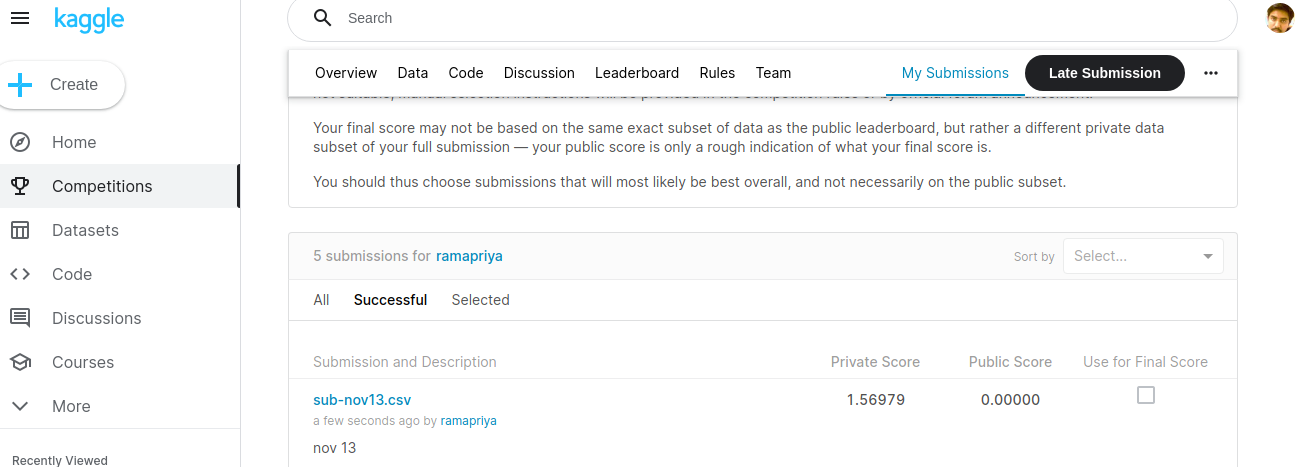

###  6.4 Metrics

In [33]:
test_df= pd.read_csv("test_clean.csv",converters={"fullVisitorId": str},
                   usecols = ['fullVisitorId','totals.totalTransactionRevenue'] )

In [34]:
test_df['totals.totalTransactionRevenue'].fillna(0, inplace=True)           # remove constant features

In [37]:
test_grp= test_df.groupby('fullVisitorId')\
           ['totals.totalTransactionRevenue'].sum().apply(np.log1p,ais=1).reset_index()

In [39]:
test_grp = pd.merge(test_grp,submit_df,on='fullVisitorId')

In [44]:
test_grp.head()

,fullVisitorId,totals.totalTransactionRevenue,PredictedLogRevenue
0,0000018966949534117,0.0,2.741567
1,0000039738481224681,0.0,0.159947
2,0000073585230191399,0.0,-0.232885
3,0000087588448856385,0.0,-0.026549
4,0000149787903119437,0.0,-0.176085


In [42]:
rms= np.sqrt(metrics.mean_squared_error(test_grp['totals.totalTransactionRevenue'],
                                        test_grp['PredictedLogRevenue']))
rms

2.207164809192847

In [41]:
metrics.mean_absolute_error(test_grp['totals.totalTransactionRevenue'],test_grp['PredictedLogRevenue'])

1.151459624456151